# 一个简单的深度神经网络的例子

我们运用神经网络来训练一个模型，用来识别图片是不是猫，数据集我们用 64*64*3的图片来作为输入，输出为一个单元，即 1 或 0,0 代表不是猫，1 代表是猫

## 1 引入我们需要的一些库

In [167]:
import numpy as np
import matplotlib.pyplot as plt

from random import randint

# 设置 matpltolib 的一些默认值
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) 
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

## 2 编写一些工具函数

> 1\) sigmoid 激活函数 sigmoid
>
> 2\) relu 激活函数 relu
>
> 3\) sigmoid_backward 激活函数求导（注：这个函数求的是 dA * g'(Z)，而 g'(Z) 才是求导函数）
>
> 4\) relu_backward 激活函数求导
>
> 5\) load_data 从文件加载数据

In [169]:
def sigmoid(Z):
    '''
    参数
    Z: shape = (output_dim, m) # output_dim 指当前层的单元数
    
    返回值
    1/(1+np.exp(-Z)): sigmoid 计算结果 shape = (output_dim, m)
    '''
    return 1/(1+np.exp(-Z))

def relu(Z):
    '''
    参数
    Z: shape = (output_dim, m) # output_dim 指当前层的单元数
    
    返回值
    np.maximum(0, Z): relu 计算结果 shape = (output_dim, m)
    '''

    return np.maximum(0,Z)

'''
计算dZ
dZ = dA * g(Z) * (1 - g(Z))
'''
def relu_backward(dA, cache):  
    '''
    dA: shape = (output_dim, m) # output_dim 为当前层的单元数
    cache: shape = (output_dim, m)
    '''
    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    
    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0
        
    return dZ

def sigmoid_backward(dA, cache):
    '''
    dA: shape = (output_dim, m) # output_dim 指当前层的单元数
    cache: shape = (output_dim, m)
    '''
    Z = cache
    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    assert (dZ.shape == Z.shape)
    
    return dZ


def load_data():
    # 把文件读取到内存中
    train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # 训练集特征
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # 训练标签

    test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # 测试集特征
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # 测试标签

    classes = np.array(test_dataset["list_classes"][:]) # 类别，即 1 和 0
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

## 3 定义神经网络的结构

input_dim 代表输入维度

output_dim 代表输出维度

activation 代表当前层所用的激活函数

In [2]:
# 定义神经网络的结构
'''
即有四层，第一层为 12288 的输入，第二层有 20 个单元 ......
'''
nn_architecture = [
    {'input_dim': 12288, 'output_dim': 20, 'activation': 'relu'},
    {'input_dim': 20, 'output_dim': 7, 'activation': 'relu'},
    {'input_dim': 7, 'output_dim': 5, 'activation': 'relu'},
    {'input_dim': 5, 'output_dim': 1, 'activation': 'sigmoid'}
]


## 4 根据网络结构随机初始化参数 W，b

In [5]:
# 根据结构随机初始化参数 W, b
def init_params(nn_architecture):
    np.random.seed(1)
    
    params = {}
    for id, layer in enumerate(nn_architecture):
        # layer_id -> [1, 2, 3, 4]
        layer_id = id + 1
        params['W' + str(layer_id)] = np.random.randn(layer['output_dim'], layer['input_dim']) / np.sqrt(layer['input_dim'])
        params['b' + str(layer_id)] = np.zeros((layer['output_dim'], 1))
    
    return params

## 5 前向传播

In [15]:
# 单层前向传播
def layer_forward(W_curr, b_curr, A_prev, activation):
    '''
    计算
    Z_curr = W_curr·A_prev + b_curr
    A_curr = g(Z_curr)
    
    参数
    W_curr: 当前层的 W 参数
    b_curr: 当前层的 b 参数
    A_prev: 上一层的 A 矩阵
    activation: 当前层要用的激活函数
    
    返回值
    Z_curr: 当前层的 Z
    A_curr: 当前层的 A
    '''
    Z_curr = np.dot(W_curr, A_prev) + b_curr
    
    # 判断激活函数并求 A
    if activation == 'relu':
        A_curr = relu(Z_curr)
    elif activation == 'sigmoid':
        A_curr = sigmoid(Z_curr)
    else:
        raise Exception('不支持的激活函数类型！')
    
    return Z_curr, A_curr

In [48]:
# 完整前向传播
def full_forward(X, params, nn_architecture):
    '''
    参数
    X: 输入
    params: W, b 参数存放的变量
    nn_architecture: 结构
    
    caches 存储格式
    因为反向传播的时候也要用到上一层的 A，
    所以这里把上一层的 A，当前层的 Z 存入到 caches 中，方便调用
    caches = [
    {'A_prev': A_prev, 'Z_curr': Z_curr}, # 第一层存储的数据
    {'A_prev': A_prev, 'Z_curr': Z_curr}, 
    .
    .
    ]
    
    返回值
    A_curr: 最后一层的 A ,也就是 AL(Y_hat)
    caches: 存放上一层的 A 和 当前层的 Z 的列表
    '''
    caches = []
    
    # X 作为 第零层 A
    A_curr = X
    
    for id, layer in enumerate(nn_architecture):
        # layer_id -> [1, 2, 3, 4]
        layer_id = id + 1
        
        # 获取上一层的 A
        A_prev = A_curr
        
        # 从 params 中获取当前层的 W 和 b
        W_curr = params['W' + str(layer_id)]
        b_curr = params['b' + str(layer_id)]
        # 从 layer 中获取激活函数
        activation = layer['activation']
        
        # 求当前层的 Z 和 A
        Z_curr, A_curr = layer_forward(W_curr, b_curr, A_prev, activation)
        
        # 把 上一层的 A 和 当前层的 Z 放入内存
        caches.append({
            'A_prev': A_prev,
            'Z_curr': Z_curr
        })
    return A_curr, caches

## 6 计算损失和准确度

In [170]:
# 获取损失值
def get_cost(Y_hat, Y):
    # 获取样本数量
    m = Y_hat.shape[1]
    
    cost = -1 / m * (np.dot(Y, np.log(Y_hat).T) + np.dot(1 - Y, np.log(1 - Y_hat).T))
    
    # cost 为一个一行一列的数据[[0.256654]], np.squeeze 让其变成一个数值
    cost = np.squeeze(cost)
    
    return cost

In [171]:
# 把预测值进行分类，预测值求出来都是一些小数，对于二分类问题，我们把对他分成两类
def convert_into_class(Y_hat):
    # 复制矩阵
    prob = np.copy(Y_hat)
    # 把矩阵里面所有的 >0.5 归类为 1
    #                  <=0.5 归类为 0
    prob[prob > 0.5] = 1
    prob[prob <= 0.5] = 0
    
    return prob

In [118]:
# 获取准确度
def get_accuracy(Y_hat, Y):
    # 先进行分类，再求精度
    prob = convert_into_class(Y_hat)
#     accu = float(np.dot(Y, prob.T) + np.dot(1 - Y, 1 - prob.T)) / float(Y_hat.shape[1])
    # 上面的注释的方法也可求精确度
    accu = np.sum((prob == Y) / Y_hat.shape[1])
    accu = np.squeeze(accu)
    
    return accu

## 7 反向传播

In [87]:
# 单层反向传播
def layer_backward(dA_curr, W_curr, Z_curr, A_prev, activation):
    '''
    计算
    dZ = dA * g(Z) * (1 - g(Z))
    dW = dZ·A.T / m
    db = np.sum(dZ, axis=1, keepdims=True) / m
    
    参数
    dA_curr: 当前层的 dA
    W_curr: 当前层的 W 参数
    Z_curr: 当前层的 Z 参数
    A_prev: 上一层的 A 参数
    activation: 当前层的激活函数
    
    返回值
    dW_curr: 当前层的 dW
    db_curr: 当前层的 db
    dA_prev: 上一层的 dA
    '''
    m = A_prev.shape[1] # 求出样本个数
    # 求出 dZ_curr
    if activation == 'relu':
        dZ_curr = relu_backward(dA_curr, Z_curr)
    elif activation == 'sigmoid':
        dZ_curr = sigmoid_backward(dA_curr, Z_curr)
    else:
        raise Exception ("不支持的激活函数类型！")
        
    dW_curr = np.dot(dZ_curr, A_prev.T) / m
    db_curr = np.sum(dZ_curr, axis=1, keepdims=True) / m
    dA_prev = np.dot(W_curr.T, dZ_curr)
    
    return dW_curr, db_curr, dA_prev


In [49]:
# 完整反向传播
def full_backward(Y_hat, Y, params, caches, nn_architecture):
    '''
    参数
    Y_hat: 预测值(最后一层的 A 值)
    Y: 真实 Y 矩阵
    params: 存放每层 W, b 参数
    caches: 存放有前向传播中的 A , Z 
    nn_architecture: 结构
    
    返回
    grads: 梯度值
    '''
    # 存放要进行梯度下降的 dW, db 参数，存放形式和 params 一样
    grads = {}
    
    # 计算最后一层的 dA
    dA_prev = - (np.divide(Y, Y_hat) - np.divide(1 - Y, 1 - Y_hat))
    
    for id, layer in reversed(list(enumerate(nn_architecture))):
        # layer_id -> [4, 3, 2, 1]
        layer_id = id + 1
        
        # 当前层的 dA 为上一次计算出来的 dA_prev
        dA_curr = dA_prev
        # 从 params 中取出 当前层的 W 参数
        W_curr = params['W' + str(layer_id)]
        # 从 caches 内存中取出我们在前向传播中存放的数据
        A_prev = caches[id]['A_prev']
        Z_curr = caches[id]['Z_curr']
        # 从当前层的结构中取出激活函数
        activation = layer['activation']
        
        # 计算当前层的梯度值 dW, db，以及上一层的 dA
        dW_curr, db_curr, dA_prev = layer_backward(dA_curr,
                                                   W_curr, 
                                                   Z_curr,
                                                   A_prev,
                                                   activation)
        # 把梯度值放入 grads 中
        grads['dW' + str(layer_id)] = dW_curr
        grads['db' + str(layer_id)] = db_curr
    
    return grads

## 8 更新参数

In [90]:
# 更新参数
def update_params(params, grads, learning_rate):
    '''
    参数
    params: W,b 参数
    grads: 梯度值
    learning_rate: 梯度下降时的学习率
    
    返回
    params: 更新后的参数
    '''
    for id in range(len(params) // 2):
        # layer_id -> [1, 2, 3, 4]
        layer_id = id + 1
        params['W' + str(layer_id)] -= learning_rate * grads['dW' + str(layer_id)]
        params['b' + str(layer_id)] -= learning_rate * grads['db' + str(layer_id)]
    
    return params

## 9 定义这个模型

In [172]:
# 定义模型
def dnn_model(X, Y, nn_architecture, epochs=2000, learning_rate=0.0075):
    np.random.seed(1)
    params = init_params(nn_architecture)
    costs = []
    
    for i in range(1, epochs + 1):
        # 前向传播
        Y_hat, caches = full_forward(X, params, nn_architecture)
        
        # 计算损失
        cost = get_cost(Y_hat, Y)
        
        # 计算精度
        accu = get_accuracy(Y_hat, Y)
        
        # 反向传播
        grads = full_backward(Y_hat, Y, params, caches, nn_architecture)
        
        # 更新参数
        params = update_params(params, grads, learning_rate)
        
        if i % 100 == 0:
            print ('Iter: {:05}, cost: {:.5f}, accu: {:.5f}'.format(i, cost, accu))
            costs.append(cost)
            
    # 画出 cost 曲线图
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return params 

## 10 加载数据并进行归一化

In [173]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

m_train = train_x_orig.shape[0] # 训练样本的数量
m_test = test_x_orig.shape[0] # 测试样本的数量
num_px = test_x_orig.shape[1] # 每张图片的宽/高

# 为了方便后面进行矩阵运算，我们需要将样本数据进行扁平化和转置
# 处理后的数组各维度的含义是（图片数据，样本数）
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T 

# 下面我们对特征数据进行了简单的标准化处理（除以255，使所有值都在[0，1]范围内）
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.


In [132]:
# 预测函数
def predict(X, Y, params, nn_architecture):
    Y_hat, _ = full_forward(X, params, nn_architecture)
    accu = get_accuracy(Y_hat, Y)
    print ('预测精确度为：{:.2f}'.format(accu))
    return Y_hat

Iter: 00100, cost: 0.67239, accu: 0.67943
Iter: 00200, cost: 0.64575, accu: 0.74641
Iter: 00300, cost: 0.62782, accu: 0.72727
Iter: 00400, cost: 0.59732, accu: 0.75598
Iter: 00500, cost: 0.52155, accu: 0.85646
Iter: 00600, cost: 0.48313, accu: 0.87560
Iter: 00700, cost: 0.43010, accu: 0.91866
Iter: 00800, cost: 0.36453, accu: 0.95694
Iter: 00900, cost: 0.34318, accu: 0.93780
Iter: 01000, cost: 0.29341, accu: 0.95215
Iter: 01100, cost: 0.25503, accu: 0.96172
Iter: 01200, cost: 0.22804, accu: 0.97608
Iter: 01300, cost: 0.19706, accu: 0.97608
Iter: 01400, cost: 0.18372, accu: 0.98086
Iter: 01500, cost: 0.16100, accu: 0.98086
Iter: 01600, cost: 0.14842, accu: 0.98086
Iter: 01700, cost: 0.13803, accu: 0.98086
Iter: 01800, cost: 0.12873, accu: 0.98086
Iter: 01900, cost: 0.12087, accu: 0.98086
Iter: 02000, cost: 0.11427, accu: 0.98086


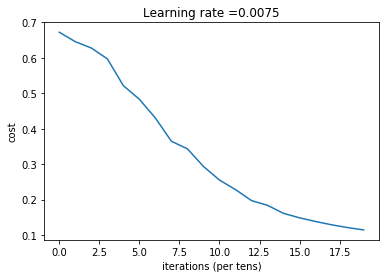

In [129]:
# 开始训练
params = dnn_model(
    train_x, train_y,
    nn_architecture,
)

In [133]:
# 预测测试集的精确度
Y_hat = predict(test_x, test_y, params, nn_architecture)

预测精确度为：0.80


这张图片不是猫
预测图片不是猫
预测正确！


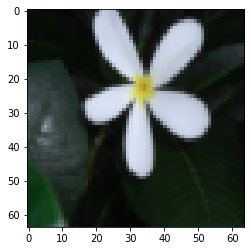

In [168]:
# 显示图片
# 因为测试集有 50 张图片，所以我们随机生成 1-50 的整形数字
index = randint(1, 49)
# 因为在前面，我们把数据展开成了 (12288, 50) 的矩阵，现在让它回归成图片的矩阵
img = test_x[:, index].reshape((64, 64, 3))
# 显示图片
plt.imshow(img)
# 把预测分类
Y_hat_ = convert_into_class(Y_hat)

# 把 1，0 转化成汉字并输出
pred_ = '是' if int(Y_hat_[0, index]) else '不是'
true_ = '是' if int(test_y[0, index]) else '不是'
print ('这张图片' + true_ + '猫')
print ('预测图片' + pred_ + '猫')

# 判断是否预测正确
if int(Y_hat_[0, index]) == int(test_y[0, index]):
    print ('预测正确！')
else:
    print ('预测错误！')